In [1]:
# Actor-Critic for Grid-World

## 必要なライブラリをインポートします
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random


In [2]:

## 環境の設定
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.state = np.zeros((size, size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        self.goal = [size-1, size-1]
    
    def reset(self):
        self.state = np.zeros((self.size, self.size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        return self.state.flatten()

    def step(self, action):
        if self.done:
            raise ValueError("Game is done")
        
        if action == 0 and self.pos[1] > 0:   # Left
            self.pos[1] -= 1
        elif action == 1 and self.pos[1] < self.size - 1:  # Right
            self.pos[1] += 1
        elif action == 2 and self.pos[0] > 0:  # Up
            self.pos[0] -= 1
        elif action == 3 and self.pos[0] < self.size - 1:  # Down
            self.pos[0] += 1
        
        self.state = np.zeros((self.size, self.size))
        self.state[self.pos[0], self.pos[1]] = 1
        
        reward = -1
        if self.pos == self.goal:
            reward = 0
            self.done = True
        
        return self.state.flatten(), reward, self.done

## Actor-Criticモデルの定義
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_size)
        self.fc_critic = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        actor_output = F.softmax(self.fc_actor(x), dim=-1)
        critic_output = self.fc_critic(x)
        return actor_output, critic_output

## エージェントの定義
class Agent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=0.001):
        self.actor_critic = ActorCritic(state_size, action_size)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.actor_critic(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def update(self, log_probs, values, rewards, next_value, dones):
        Qvals = np.zeros(len(rewards))
        Qval = next_value
        
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + self.gamma * Qval * (1 - dones[t])
            Qvals[t] = Qval
        
        Qvals = torch.tensor(Qvals)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        
        actor_loss = (-log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [3]:

## 環境とエージェントの設定
env = GridWorld(size=4)
state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 1000
max_t = 100
scores = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    agent.update(log_probs, values, rewards, next_value, dones)
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


Episode 100/1000, Average Score: -47.13
Episode 200/1000, Average Score: -49.55
Episode 300/1000, Average Score: -65.03
Episode 400/1000, Average Score: -14.27
Episode 500/1000, Average Score: -8.25
Episode 600/1000, Average Score: -8.35
Episode 700/1000, Average Score: -7.84
Episode 800/1000, Average Score: -8.01
Episode 900/1000, Average Score: -7.91
Episode 1000/1000, Average Score: -7.84


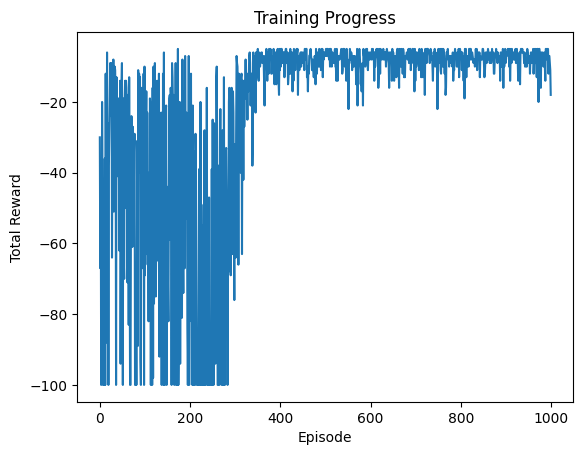

In [4]:

## 結果の表示
import matplotlib.pyplot as plt

plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


In [23]:
## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state)
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
    print(policy_grid)

## 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


[['>' '>' '>' '>']
 ['v' 'v' '>' 'v']
 ['v' 'v' '>' 'v']
 ['>' '>' 'v' 'G']]


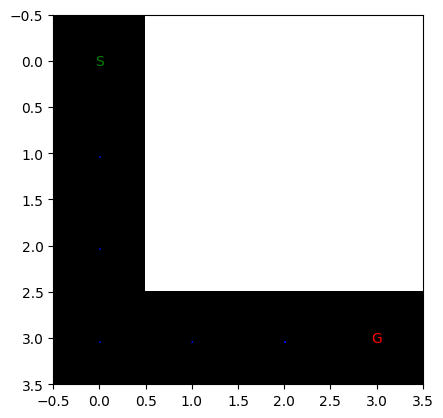

In [12]:
## エピソードを走らせて経路を取得する関数
def run_episode(agent, env):
    state = env.reset()
    states = [state.reshape(env.size, env.size).copy()]
    actions = []
    done = False

    while not done:
        action, _ = agent.select_action(state)
        actions.append(action)
        state, reward, done = env.step(action)
        states.append(state.reshape(env.size, env.size).copy())

    return states, actions

## 経路を可視化する関数
def plot_episode_path(states, env):
    path = np.zeros_like(states[0])
    for state in states:
        path += state

    path = np.clip(path, 0, 1)  # 値を0か1にクリップする
    fig, ax = plt.subplots()
    ax.imshow(path, cmap="Greys", origin="upper")

    for i, state in enumerate(states):
        pos = np.argwhere(state == 1)[0]
        if i == 0:
            ax.text(pos[1], pos[0], 'S', ha='center', va='center', color='green')
        elif i == len(states) - 1:
            ax.text(pos[1], pos[0], 'G', ha='center', va='center', color='red')
        else:
            ax.text(pos[1], pos[0], '.', ha='center', va='center', color='blue')

    ax.set_xticks(np.arange(-.5, env.size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, env.size, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)

    plt.show()

## エピソードを走らせて経路を可視化
states, actions = run_episode(agent, env)
plot_episode_path(states, env)


In [14]:
## エピソードを走らせたときの経路を可視化する関数
def visualize_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state)
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    grid[env.goal[0], env.goal[1]] = 'G'  # ゴールの位置を設定
    
    print(grid)

## エピソードを実行して経路を可視化
path = visualize_episode(agent, env)
plot_path(path, env)


[['o' '-' '-' '-']
 ['o' 'o' '-' '-']
 ['-' 'o' '-' '-']
 ['-' 'o' 'o' 'G']]
